### 32 Nearest Neighbors for our "eight" image:

The MNIST competition is slowly coming to an end so I figured I'd try something slightly different - let's try to see if we can get some intuition about the geometry and topology of the space in which the digits sit.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/train.csv")

X_train = train.iloc[:,1:].values
X_train = X_train.reshape(X_train.shape[0], 28, 28) #reshape to rectangular
X_train = X_train/255 #pixel values are 0 - 255 - this makes puts them in the range 0 - 1

y = train["label"].values

In [3]:
#define a function that allows us to see the digits:
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

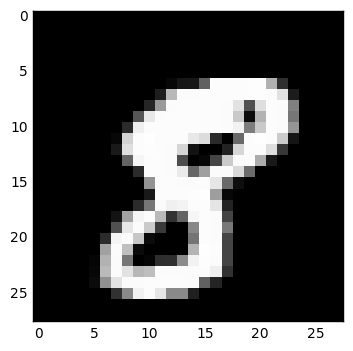

In [4]:
img = X_train[10]
show(img)

It's an 8!

Ok so our digits are in a space in which every pixel is a variable or a feature. Since there are 28*28 = 784 pixels per image we can thing of the images as sitting in $$R^{784}$$ or $$R^{28*28}$$

However this space is very high dimensional and most dimensionality reduction techniques try to exploit the intuition that not all of these dimension are needed to distinguish between the digits (or more generally extract features or achieve some learning task).

Where does this intuition come from? To see this let's generate point uniformly at random in the unit 784 dimensional hypercube and see what it looks like:

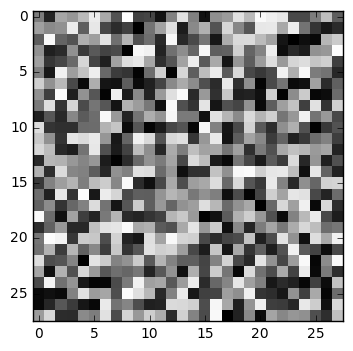

In [5]:
#generating a random 28 by 28 image:
rand_img = np.random.randint(0, 255, (28, 28))
rand_img = rand_img/255.0

show(rand_img)

Doesn't look like anything to me.

We can try to sample at random many times but unless we get extremely lucky all we'll get is static and nothing resembling an actual digit. This is good empirical evidence that the meaningful images - in this case images of digits, are clustered in smaller dimensional subsets in the original 784 dimensional pixel space. This is what is called the **manifold hypothesis**. And the promise is that if we better understand the structure of the manifold we will have an easier time building machine learning systems.

Before we try to see how to figure out the manifold structure let's take a closer look at out space. For example what happens if we start at the point of a digit and start traveling in a random direction? Will we get any meaningful images?

In [6]:
rand_direction = np.random.rand(28, 28) 

### Moving in a random direction away from a digit in the 784 dimensional image space:

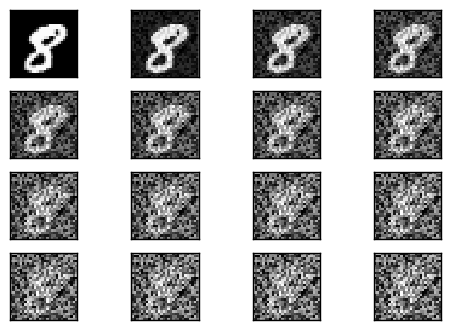

In [7]:
for i in range(16):
    plt.subplot(4,4,i+1)
    show(img + i/4*rand_direction)    
    plt.xticks([])
    plt.yticks([])

As we can see as we move away from the digit, the images we encounter become less and less distinguishable. At first we can still see it's an eight but before we know it we're back in static land.

Perhaps a good analogy here is that of a solar system: the surface of our planets are the manifolds we're interested in, one for each digit. Now say you're on the surface of the earth which is a 2-manifold, namely a sphere, and we start moving in a random direction (let's assume gravity doesn't exist and you can go thru solid objects). If you don't understand the structure of earth you'll quickly find yourself in space or inside the earth. But if you instead move within the local earth (say spherical) coordinates you will stay on the surface and get to see all the cool stuff.

There are however some differences: first of all we're in a much higher dimensional space and we're not sure how many dimensions we need to capture the structure of the digit subspaces. Secondly these subspaces could be really crazy looking - think for example two donuts entangled in some weird way. You could in fact get from one manifold to another without going into static space as all.

### Our digits' best friends aka Nearest Neighbors:

Another thing to do to understand better the structure of the image space is to look at what images are closest to the "eight" image using some metric. In this case I'll use the sklearn knn wrap with l_2 distance as the metric on the flattened images. 

In [8]:
X_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

knn = NearestNeighbors(5000)

knn.fit(X_flat[:5000])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5000, p=2, radius=1.0)

In [9]:
distances, neighbors = knn.kneighbors(img.flatten().reshape(1, -1))
neighbors = neighbors[0]
distances = distances[0]

### Histogram of L_2 distances from the "eight" digit:

(array([    8.,    28.,   120.,   408.,   852.,  1346.,  1257.,   711.,
          218.,    51.]),
 array([  6.93865358,   7.66124204,   8.38383049,   9.10641895,
          9.8290074 ,  10.55159586,  11.27418432,  11.99677277,
         12.71936123,  13.44194968,  14.16453814]),
 <a list of 10 Patch objects>)

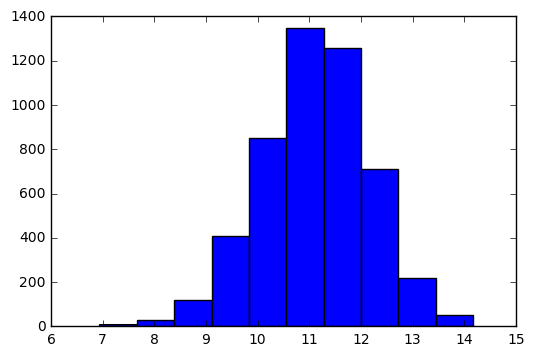

In [10]:
plt.hist(distances[1:])

The distances of the first 5000 images from the "eight" image is roughly normally distributed - in fact it's much more well behaved than I expected. At first I though I'd see multiple modes and a higher variance given that we have different classes. 

### 32 Nearest Neighbors for our "eight" image:

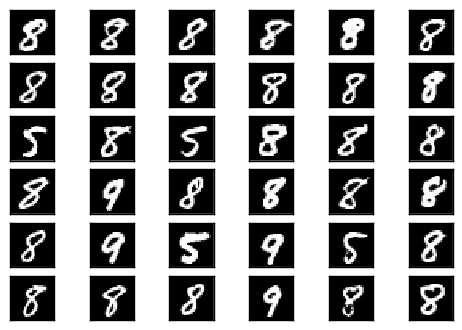

In [11]:
for digit_num, num in enumerate(neighbors[:36]):
    plt.subplot(6,6,digit_num+1)
    grid_data = X_train[num]  # reshape from 1d to 2d pixel array
    show(grid_data)
    plt.xticks([])
    plt.yticks([])

Interesting stuff - most of the neighbors are also eight but not all - we see some five and some nines as well. However all in all it looks like KNN would be a decent way to attack this problem - maybe with 5 or 10 neighbors.

### Learning the manifold with an autoencoder:

Ok so how do figure out what dimensions in the image space are important? One option would be to hand engineer features - for examples the mean of all pixels is probably a good feature to have. Other worthwhile features would be slant, vertical and horizontal symmetry. 

But we want do to machine learning not hand craft features because we're lazy. We're going to use an autoencoder. 

An **autoencoder ** is a feed- forward neural network who tries to learn a lower dimensional representation of our data. How does it do that? Well the input is the actual image and the target is also the image. 

Since the autoencoder is forced to reconstruct the images from a smaller representation it discards any variation that it doesn't find useful. Here is a great description form the really great [Deep Learning](http://www.deeplearningbook.org/contents/autoencoders.html) book:

"The important principle is that the autoencoder can aﬀord to represent only the variations that are needed to reconstruct training examples. If the data generating distribution concentrates near a low-dimensional manifold, this yields representations that implicitly capture a local coordinate system for this manifold: only the variations tangent to the manifold around x need to correspond to changes in h=f(x)."

In [13]:
input_img = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_img)

encoded = Dense(4)(encoded) #keep it linear here.

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)

In [14]:
autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.fit(X_flat, X_flat, batch_size = 128, nb_epoch = 5)